# Stochastic Solver: Heterodyne Detection

Copyright (C) 2011 and later, Paul D. Nation & Robert J. Johansson

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from qutip import (
    SMESolver,
    about,
    coherent,
    destroy,
    mesolve,
    plot_expectation_values,
    smesolve,
)

%matplotlib inline

## Introduction

Homodyne and hetrodyne detection are techniques for measuring the quadratures of a field using photocounters. Homodyne detection (on-resonant) measures one quadrature and with heterodyne detection (off-resonant) both quadratures can be detected simulateously.

The evolution of a quantum system that is coupled to a field that is monitored with homodyne and heterodyne detector can be described with stochastic master equations. This notebook compares two different ways to implement the heterodyne detection stochastic master equation in QuTiP.

## Deterministic reference

In [2]:
N = 15
w0 = 1.0 * 2 * np.pi
A = 0.1 * 2 * np.pi
times = np.linspace(0, 10, 201)
gamma = 0.25
ntraj = 50

a = destroy(N)
x = a + a.dag()
y = -1.0j * (a - a.dag())

H = w0 * a.dag() * a + A * (a + a.dag())

rho0 = coherent(N, np.sqrt(5.0), method="analytic")
c_ops = [np.sqrt(gamma) * a]
e_ops = [a.dag() * a, x, y]

In [3]:
result_ref = mesolve(H, rho0, times, c_ops, e_ops)

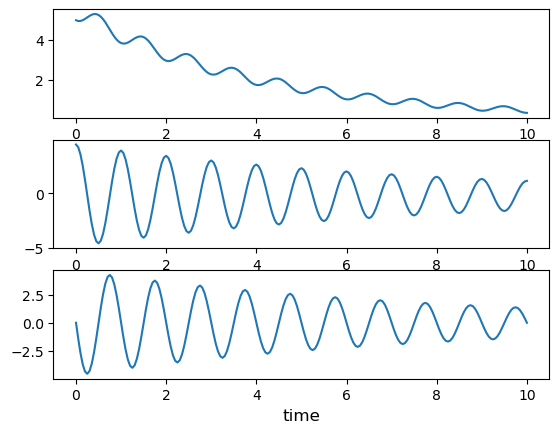

In [4]:
plot_expectation_values(result_ref);

## Heterodyne implementation #1

Stochastic master equation for heterodyne in Milburn's formulation

$\displaystyle d\rho(t) = -i[H, \rho(t)]dt + \gamma\mathcal{D}[a]\rho(t) dt + \frac{1}{\sqrt{2}} dW_1(t) \sqrt{\gamma} \mathcal{H}[a] \rho(t) + \frac{1}{\sqrt{2}} dW_2(t) \sqrt{\gamma} \mathcal{H}[-ia] \rho(t)$

where $\mathcal{D}$ is the standard Lindblad dissipator superoperator, and $\mathcal{H}$ is defined as above,
and $dW_i(t)$ is a normal distributed increment with $E[dW_i(t)] = \sqrt{dt}$.


In QuTiP, this is available with the stochactic master equation solver ``smesolve`` and ``SMESolver`` with heterodyne detection.

The heterodyne currents for the $x$ and $y$ quadratures are

$J_x(t) = \sqrt{\gamma}\left<x\right> + \sqrt{2} \xi(t)$

$J_y(t) = \sqrt{\gamma}\left<y\right> + \sqrt{2} \xi(t)$

where $\xi(t) = \frac{dW}{dt}$.

In qutip, these measurements are build from the operators passed as ``sc_ops``.

In [5]:
options = {"store_measurement": True, "map": "parallel"}

result = smesolve(
    H,
    rho0,
    times,
    sc_ops=c_ops,
    heterodyne=True,
    e_ops=e_ops,
    ntraj=ntraj,
    options=options,
)

10.0%. Run time:   1.64s. Est. time left: 00:00:00:14


20.0%. Run time:   2.47s. Est. time left: 00:00:00:09


30.0%. Run time:   3.30s. Est. time left: 00:00:00:07


40.0%. Run time:   4.13s. Est. time left: 00:00:00:06


50.0%. Run time:   5.72s. Est. time left: 00:00:00:05


60.0%. Run time:   6.53s. Est. time left: 00:00:00:04


70.0%. Run time:   7.36s. Est. time left: 00:00:00:03


80.0%. Run time:   8.20s. Est. time left: 00:00:00:02


90.0%. Run time:   9.79s. Est. time left: 00:00:00:01


100.0%. Run time:  10.26s. Est. time left: 00:00:00:00


Total run time:  10.27s


(<Figure size 640x480 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:xlabel='time'>],
       dtype=object))

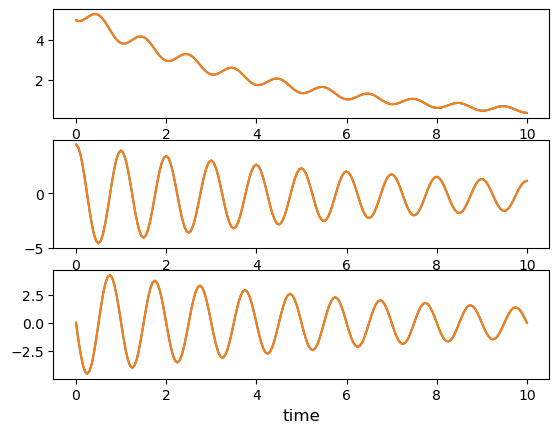

In [6]:
plot_expectation_values([result, result_ref])

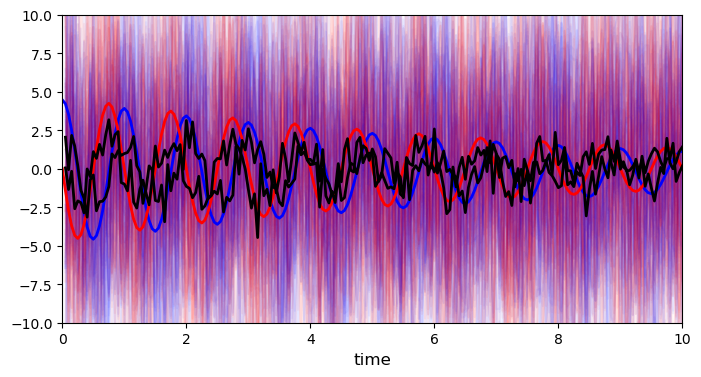

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))

for m in result.measurement:
    ax.plot(times[1:], m[0, 0, :].real, "b", alpha=0.05)
    ax.plot(times[1:], m[0, 1, :].real, "r", alpha=0.05)

ax.plot(times, result_ref.expect[1], "b", lw=2)
ax.plot(times, result_ref.expect[2], "r", lw=2)

ax.set_ylim(-10, 10)
ax.set_xlim(0, times.max())
ax.set_xlabel("time", fontsize=12)
ax.plot(times[1:], np.mean(result.measurement, axis=0)[0, 0, :].real, "k", lw=2)
ax.plot(times[1:], np.mean(result.measurement, axis=0)[0, 1, :].real, "k", lw=2)

## Heterodyne implementation #2: using two homodyne measurements

We can also write the heterodyne equation as

$\displaystyle d\rho(t) = -i[H, \rho(t)]dt + \frac{1}{2}\gamma\mathcal{D}[a]\rho(t) dt + \frac{1}{\sqrt{2}} dW_1(t) \sqrt{\gamma} \mathcal{H}[a] \rho(t) + \frac{1}{2}\gamma\mathcal{D}[a]\rho(t) dt + \frac{1}{\sqrt{2}} dW_2(t) \sqrt{\gamma} \mathcal{H}[-ia] \rho(t)$


Which correspond to the homodyne detection with two stochastic collapse operators:  $A_1 = \sqrt{\gamma} a / \sqrt{2}$ and $A_2 = -i \sqrt{\gamma} a / \sqrt{2}$.

Here the two homodyne currents associated to this problem are

$J_x(t) = \sqrt{\gamma/2}\left<x\right> + \xi(t)$

$J_y(t) = \sqrt{\gamma/2}\left<y\right> + \xi(t)$

where $\xi(t) = \frac{dW}{dt}$.

However, we desire the homodyne currents for the $x$ and $y$ quadratures:

$J_x(t) = \sqrt{\gamma}\left<x\right> + \sqrt{2}\xi(t)$

$J_y(t) = \sqrt{\gamma}\left<y\right> + \sqrt{2}\xi(t)$

In qutip we can use the predefined homodyne solver for solving this problem, but rescale the `m_ops` and `dW_factors`.

In [8]:
options = {
    "method": "platen",
    "dt": 0.001,
    "store_measurement": True,
    "map": "parallel",
}
sc_ops = [np.sqrt(gamma / 2) * a, -1.0j * np.sqrt(gamma / 2) * a]

solver = SMESolver(H, sc_ops=sc_ops, heterodyne=False, options=options)
solver.m_ops = [np.sqrt(gamma) * x, np.sqrt(gamma) * y]
solver.dW_factors = [np.sqrt(2), np.sqrt(2)]
result = solver.run(rho0, times, e_ops=e_ops, ntraj=ntraj)

10.0%. Run time:   1.65s. Est. time left: 00:00:00:14


20.0%. Run time:   2.49s. Est. time left: 00:00:00:09


30.0%. Run time:   3.31s. Est. time left: 00:00:00:07


40.0%. Run time:   4.14s. Est. time left: 00:00:00:06


50.0%. Run time:   5.75s. Est. time left: 00:00:00:05


60.0%. Run time:   6.58s. Est. time left: 00:00:00:04


70.0%. Run time:   7.41s. Est. time left: 00:00:00:03


80.0%. Run time:   8.25s. Est. time left: 00:00:00:02


90.0%. Run time:   9.85s. Est. time left: 00:00:00:01


100.0%. Run time:  10.31s. Est. time left: 00:00:00:00


Total run time:  10.32s


(<Figure size 640x480 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:xlabel='time'>],
       dtype=object))

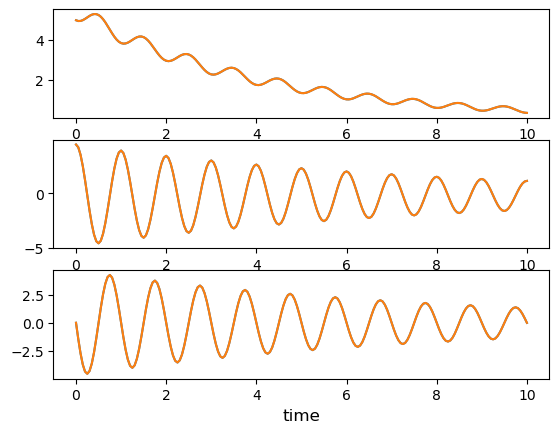

In [9]:
plot_expectation_values([result, result_ref])

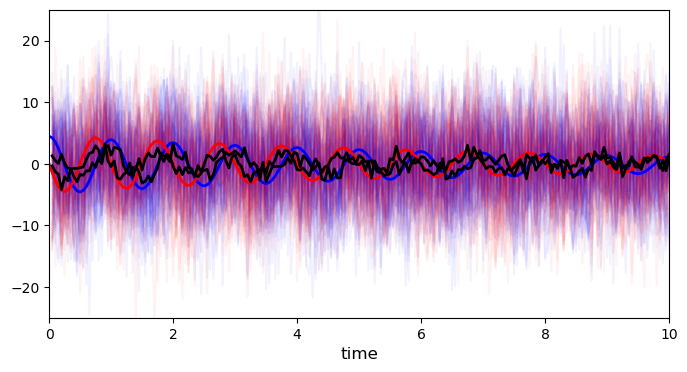

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))

for m in result.measurement:
    ax.plot(times[1:], m[0, :].real, "b", alpha=0.05)
    ax.plot(times[1:], m[1, :].real, "r", alpha=0.05)

ax.plot(times, result_ref.expect[1], "b", lw=2)
ax.plot(times, result_ref.expect[2], "r", lw=2)

ax.set_xlim(0, times.max())
ax.set_ylim(-25, 25)
ax.set_xlabel("time", fontsize=12)
ax.plot(
    times[1:], np.array(result.measurement).mean(axis=0)[0, :].real, "k", lw=2
)
ax.plot(
    times[1:], np.array(result.measurement).mean(axis=0)[1, :].real, "k", lw=2
)

## Common problem

For some systems, the resulting density matrix can become unphysical due to the accumulation of computation error.

In [11]:
options = {
    "method": "euler",
    "dt": 0.1,
    "store_states": True,
    "store_measurement": True,
    "map": "parallel",
}

result = smesolve(
    H,
    rho0,
    np.linspace(0, 2, 21),
    sc_ops=c_ops,
    heterodyne=True,
    e_ops=e_ops,
    ntraj=ntraj,
    options=options,
)

result.expect

10.0%. Run time:   0.05s. Est. time left: 00:00:00:00


20.0%. Run time:   0.06s. Est. time left: 00:00:00:00


30.0%. Run time:   0.07s. Est. time left: 00:00:00:00


40.0%. Run time:   0.08s. Est. time left: 00:00:00:00


50.0%. Run time:   0.09s. Est. time left: 00:00:00:00


60.0%. Run time:   0.10s. Est. time left: 00:00:00:00


70.0%. Run time:   0.11s. Est. time left: 00:00:00:00


80.0%. Run time:   0.12s. Est. time left: 00:00:00:00


90.0%. Run time:   0.13s. Est. time left: 00:00:00:00


100.0%. Run time:   0.14s. Est. time left: 00:00:00:00


Total run time:   0.15s


/usr/share/miniconda3/envs/test-environment/lib/python3.10/site-packages/qutip/solver/multitrajresult.py:847: RuntimeWarning: overflow encountered in square
  self.sum2_expect[i] += weight * expect_traj**2
/usr/share/miniconda3/envs/test-environment/lib/python3.10/site-packages/qutip/solver/multitrajresult.py:271: RuntimeWarning: overflow encountered in square
  self.std_e_data[k] = list(np.sqrt(np.abs(avg2 - np.abs(avg**2))))
/usr/share/miniconda3/envs/test-environment/lib/python3.10/site-packages/qutip/solver/multitrajresult.py:271: RuntimeWarning: invalid value encountered in subtract
  self.std_e_data[k] = list(np.sqrt(np.abs(avg2 - np.abs(avg**2))))


[array([ 4.99651005e+000,  4.87117219e+000,  4.93237387e+000,
         5.17692992e+000,  5.54811106e+000,  6.21412425e+000,
         5.76348916e+000, -9.96539498e+001, -2.66413889e+005,
        -1.86194942e+012,  4.32797984e+026,  1.49548208e+055,
         8.00182200e+111,  5.56436381e+225,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan]),
 array([ 4.46901445e+000,  4.41317438e+000,  2.51528419e+000,
        -1.19784016e+000, -6.43393138e+000, -1.59562411e+001,
        -8.77945198e+000,  1.61017534e+003,  4.12809649e+006,
         2.88816007e+013, -6.71336006e+027, -2.31972192e+056,
        -1.24120523e+113, -8.63118110e+226,              nan,
                     nan,              nan,              nan,
                     nan,              nan,              nan]),
 array([ 0.00000000e+000, -2.93244378e+000, -5.82106350e+000,
        -7.45958798e+000, -7.22034743e+000, -4.96362559e+000,
    

In [12]:
result.states[-1].full()

array([[nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,

In [13]:
sp.linalg.eigh(result.states[10].full(), eigvals_only=True)

array([-1.27098678e+29, -1.25267575e+28, -1.44224993e+26, -1.77801788e+25,
       -1.06045305e+22, -8.73003895e+18, -2.22112598e+17,  1.08790832e+10,
        6.51645479e+14,  1.66824426e+20,  2.06046544e+21,  5.32298006e+22,
        1.54238921e+27,  1.42160231e+28,  1.24029002e+29])

Using smaller integration steps by lowering the ``dt`` option will lower the numerical errors.
The solver algorithm used affect the convergence and numerical error.
Notable solvers are:  
- euler: order 0.5 fastest, but lowest order. Only solver that accept non-commuting sc_ops.
- rouchon: order 1.0?, build to keep the density matrix physical,
- taylor1.5: order 1.5, reasonably fast for good convergence.

To list list all available solver, use ``SMESolver.avail_integrators()``

In [14]:
SMESolver.avail_integrators()

{'platen': qutip.solver.sode.sode.PlatenSODE,
 'euler': qutip.solver.sode.itotaylor.EulerSODE,
 'explicit1.5': qutip.solver.sode.itotaylor.Explicit1_5_SODE,
 'rouchon': qutip.solver.sode.rouchon.RouchonSODE,
 'pred_corr': qutip.solver.sode.sode.PredCorr_SODE,
 'taylor1.5': qutip.solver.sode.itotaylor.Taylor1_5_SODE,
 'milstein': qutip.solver.sode.itotaylor.Milstein_SODE,
 'milstein_imp': qutip.solver.sode.itotaylor.Implicit_Milstein_SODE,
 'taylor1.5_imp': qutip.solver.sode.itotaylor.Implicit_Taylor1_5_SODE}

## About

In [15]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.1.0.dev0+c874c4a
Numpy Version:      1.22.4
Scipy Version:      1.13.1
Cython Version:     3.0.10
Matplotlib Version: 3.5.2
Python Version:     3.10.4
Number of CPUs:     4
BLAS Info:          Generic
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /usr/share/miniconda3/envs/test-environment/lib/python3.10/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bi